## Prophet (Pronóstico a 3 Años)

Objetivo: Entrenar un modelo Prophet optimizado utilizando el conjunto de datos "limpio" (2014-2022) de conteo de casos Alzheimer en México. Se evaluará su robustez en un pronóstico de 3 años (2023-2025), con métricas y gráficos separados para cada año.

### Paso 1: Configuración del Entorno (Librerías y Carga de Datos)

In [78]:
# --- 1. Carga de Librerías ---
import pandas as pd
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

print("Librerías importadas exitosamente.")

# --- 2. Carga de Datos (Historial y 2025) ---
print("\nCargando Datasets...")
path_historial = '../data/processed/data_processed_v3_National_NoAcum_Total.csv'
path_2025 = '../data/processed/nuevos_datos.csv'
try:
    df_historial = pd.read_csv(path_historial) # 2014-2024
    df_eval_2025 = pd.read_csv(path_2025)     # 2025
    print("Datos cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error: No se pudo encontrar un archivo. Verifica la ruta: {e.filename}")
    raise e

Librerías importadas exitosamente.

Cargando Datasets...
Datos cargados exitosamente.


### Paso 2: Preparación del DataFrame (Completo 2014-2025)

Se fusionarán todos los datos disponibles (2014-2025) en un solo DataFrame maestro. Esto nos permitirá definir limpiamente nuestro set de entrenamiento (2014-2022) y nuestro set de prueba completo (2023-2025).

In [79]:
print("\n--- Paso 2: Fusión de Todos los Datos (2014-2025) ---")

# --- 1. Preparación y Fusión ---
df_historial['Date'] = pd.to_datetime(df_historial['Date'])
df_historial = df_historial.rename(columns={'Date': 'ds', 'New_Cases': 'y'})[['ds', 'y']]

df_eval_2025['ds'] = pd.to_datetime(df_eval_2025['ds'])
df_eval_2025 = df_eval_2025.rename(columns={'y': 'y'})[['ds', 'y']]

df_prophet = pd.concat([df_historial, df_eval_2025], ignore_index=True)
print("DataFrames de 2014-2024 y 2025 fusionados.")

# --- 2. Limpieza de Frecuencia (sobre el total) ---
df_prophet = df_prophet.set_index('ds')
df_prophet = df_prophet.asfreq('W-MON') # Se mantiene el anclaje en Lunes
nans_creados = df_prophet['y'].isnull().sum()
if nans_creados > 0:
    print(f"DIAGNÓSTICO: Se encontraron {nans_creados} semanas faltantes, rellenando con 0.")
    df_prophet['y'] = df_prophet['y'].fillna(0)

df_prophet = df_prophet.reset_index()
print(f"\nDataFrame completo listo: {len(df_prophet)} semanas (hasta {df_prophet['ds'].max().date()})")


--- Paso 2: Fusión de Todos los Datos (2014-2025) ---
DataFrames de 2014-2024 y 2025 fusionados.
DIAGNÓSTICO: Se encontraron 1 semanas faltantes, rellenando con 0.

DataFrame completo listo: 616 semanas (hasta 2025-10-20)


### Paso 3: Definición de Parámetros y División de Datos (2014-2022 vs 2023-2025)

Se define la división de datos. El entrenamiento será de 2014 a 2022. La prueba será el bloque completo de 2023, 2024 y 2025. Se usará una rejilla de parámetros de 50 combinaciones, y considerando el evento de la pandemia (2 años).

In [ ]:
print("\n--- Paso 3: Definiendo Parámetros (Hipótesis 2014-2022 -> 2023-2025) ---")

# --- 1. Definición de Fechas de Corte ---
FECHA_CORTE_ENTRENAMIENTO = pd.to_datetime('2023-01-01') # Se entrena con 2014-2022
FECHA_INICIO_PRUEBA = pd.to_datetime('2023-01-01') # Se prueba con 2023 en adelante

TS_SPLITS = 3

# --- 2. Definición de la Rejilla de Hiperparámetros---
param_grid_prophet = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.05, 0.1, 0.5, 0.7, 1.0],
    'seasonality_prior_scale': [0.25, 0.5, 0.6, 0.7, 1.0]
}
all_params = [dict(zip(param_grid_prophet.keys(), v)) for v in itertools.product(*param_grid_prophet.values())]
print(f"Se probarán {len(all_params)} combinaciones de hiperparámetros.")

# --- 3. Definición de Eventos Especiales (Pandemia - 2.5 AÑOS) ---
dias_impacto_pandemia = int(2.5 * 365.25)
pandemia_covid = pd.DataFrame({
  'holiday': 'pandemia_covid',
  'ds': pd.to_datetime(['2020-03-23']),
  'lower_window': 0, 'upper_window': dias_impacto_pandemia,
})
print(f"DataFrame de eventos (Pandemia) creado con un impacto de {pandemia_covid['upper_window'][0]} días.")

# --- 4. División de Datos (2014-2022 vs 2023-2025) ---
train_data = df_prophet[df_prophet['ds'] < FECHA_CORTE_ENTRENAMIENTO]
test_data = df_prophet[df_prophet['ds'] >= FECHA_INICIO_PRUEBA]

print(f"\nDatos de entrenamiento: {len(train_data)} semanas (hasta {train_data['ds'].max().date()})")
print(f"Datos de prueba: {len(test_data)} semanas (desde {test_data['ds'].min().date()})")


--- Paso 3: Definiendo Parámetros (Hipótesis 2014-2022 -> 2023-2025) ---
Se probarán 50 combinaciones de hiperparámetros.
DataFrame de eventos (Pandemia) creado con un impacto de 913 días.

Datos de entrenamiento: 469 semanas (hasta 2022-12-26)
Datos de prueba: 147 semanas (desde 2023-01-02)


### Paso 4: Búsqueda de Hiperparámetros (Grid Search)

Se ejecutará el GridSearch sobre el set de entrenamiento "limpio" (2014-2022) para encontrar los mejores parámetros.

In [81]:
print("\n--- Paso 4: Iniciando Búsqueda de Hiperparámetros (Grid Search) ---")

# Se define el CV
tscv = TimeSeriesSplit(n_splits=TS_SPLITS)

start_time_opt = time.time()
best_rmse = float('inf')
best_params = None

# Se itera sobre la rejilla de parámetros
for params in all_params:
    rmses_fold = []
    for train_idx, val_idx in tscv.split(train_data):
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]
        try:
            m_opt = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=True,
                holidays=pandemia_covid,
                **params
            )
            m_opt.fit(train_fold)
            
            future_opt = m_opt.make_future_dataframe(periods=len(val_fold), freq='W-MON')
            forecast_opt = m_opt.predict(future_opt)
            y_pred_opt = forecast_opt.iloc[-len(val_fold):]['yhat']
            
            rmses_fold.append(np.sqrt(mean_squared_error(val_fold['y'], y_pred_opt)))
        
        except Exception as e:
            continue
            
    if rmses_fold:
        mean_rmse = np.mean(rmses_fold)
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = params

optimization_time = time.time() - start_time_opt
print(f"Tiempo de Optimización (GridSearch): {optimization_time:.2f} segundos")
print(f"Mejores parámetros encontrados: {best_params}")


--- Paso 4: Iniciando Búsqueda de Hiperparámetros (Grid Search) ---


16:52:58 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:53:00 - cmdstanpy - INFO - Chain [1] done processing
16:53:01 - cmdstanpy - INFO - Chain [1] start processing
16:53:01 - cmdstanpy - INFO - Chain [1] done processing
16:53:01 - cmdstanpy - INFO - Chain [1] start processing
16:53:02 - cmdstanpy - INFO - Chain [1] done processing
16:53:02 - cmdstanpy - INFO - Chain [1] start processing
16:53:02 - cmdstanpy - INFO - Chain [1] done processing
16:53:03 - cmdstanpy - INFO - Chain [1] start processing
16:53:03 - cmdstanpy - INFO - Chain [1] done processing
16:53:04 - cmdstanpy - INFO - Chain [1] start processing
16:53:04 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:06 - cmdstanpy - INFO - Chain [1] start processing
16:53:06 - cmdstanpy - INFO - Chain [1]

Tiempo de Optimización (GridSearch): 164.51 segundos
Mejores parámetros encontrados: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.5}


### Paso 5: Entrenamiento Final y Pronóstico a 3 Años

Se entrena el modelo final sobre los datos de 2014-2022 usando los best_params. Luego, se genera un pronóstico a largo plazo para cubrir 2023, 2024 y 2025, y se guardan las predicciones.

In [105]:
print("\n--- Paso 5: Entrenamiento Final y Pronóstico a 3 Años ---")

# --- 1. Entrenamiento del Modelo Final ---
start_time_train = time.time()

modelo_final_nacional = Prophet(
    yearly_seasonality=30,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=pandemia_covid,
    **best_params
)
modelo_final_nacional.fit(train_data) # Entrenado en 2014-2022

training_time = time.time() - start_time_train
print(f"Tiempo de Entrenamiento (Nacional): {training_time:.2f} segundos")

# --- 2. Generación del Pronóstico a 3 Años ---
horizonte_total = len(test_data) # Total de semanas en 2023, 2024 y 2025
future_final = modelo_final_nacional.make_future_dataframe(periods=horizonte_total, freq='W-MON')
forecast_final = modelo_final_nacional.predict(future_final)

# --- 3. Creación del DataFrame de Evaluación (df_eval) ---
# Se crea un DataFrame que alinea los Reales (2023-2025) con las Predicciones
df_eval = pd.merge(
    test_data, # Contiene 'ds' e 'y' real
    forecast_final[['ds', 'yhat']], # Contiene 'ds' y 'yhat' predicho
    on='ds',
    how='left'
)

print(f"\nDataFrame de Evaluación (2023-2025) creado con {len(df_eval)} semanas.")


--- Paso 5: Entrenamiento Final y Pronóstico a 3 Años ---


17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo de Entrenamiento (Nacional): 2.01 segundos

DataFrame de Evaluación (2023-2025) creado con 147 semanas.


### Paso 6: Evaluación Multi-Periodo

Se evalúa el rendimiento del pronóstico de 3 años en bloques separados (2023, 2024, 2025) y en conjunto, para entender cómo se acumula el error a medida que el modelo se aleja de sus datos de entrenamiento.


--- Paso 6: Evaluación Multi-Periodo ---

--- Métricas para el período: 2023 (Año 1 del Pronóstico) ---
MAPE: 15.33%
RMSE: 9.09
MAE:  7.67


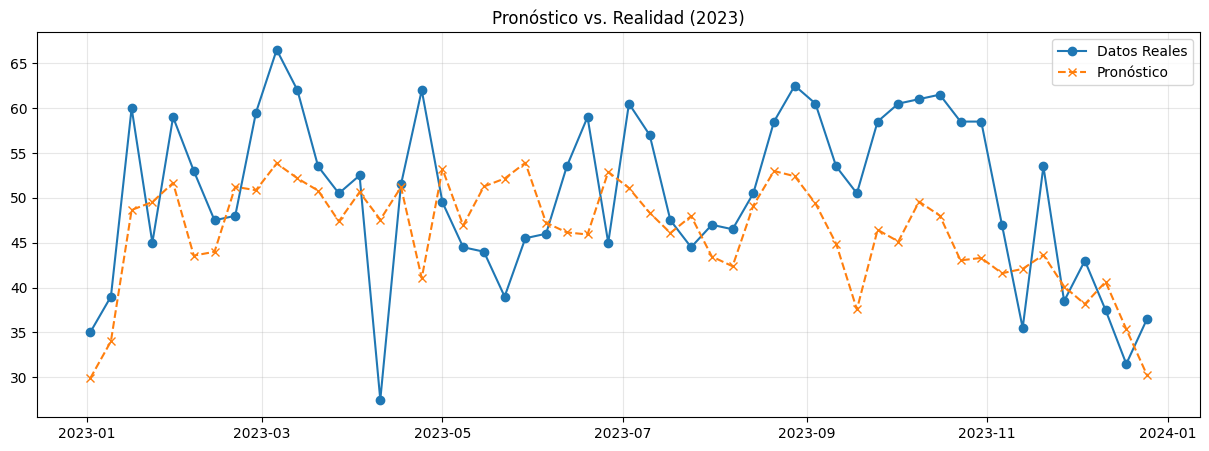


--- Métricas para el período: 2024 (Año 2 del Pronóstico) ---
MAPE: 18.42%
RMSE: 8.49
MAE:  7.33


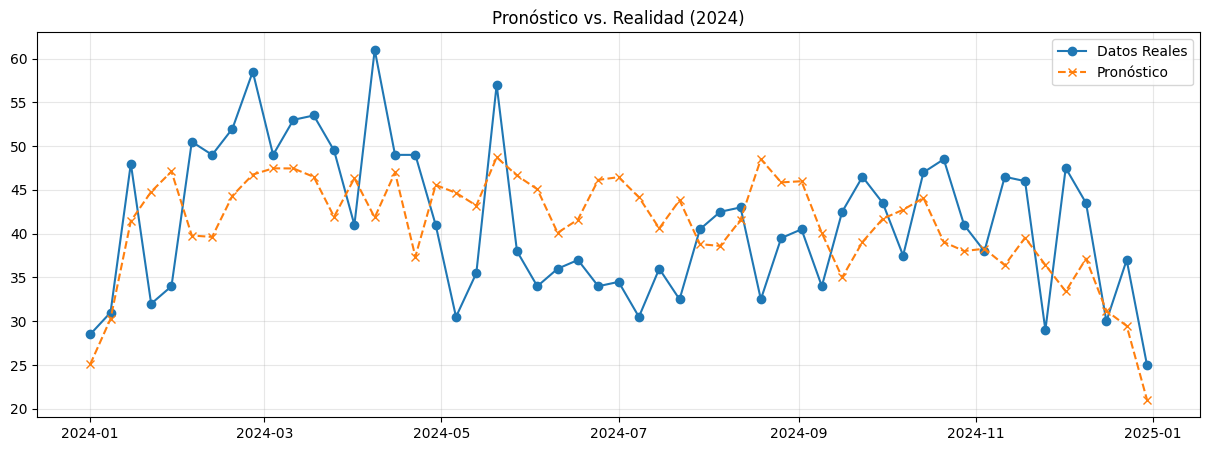


--- Métricas para el período: 2025 (Año 3 del Pronóstico) ---
MAPE: 16.71%
RMSE: 8.95
MAE:  6.66


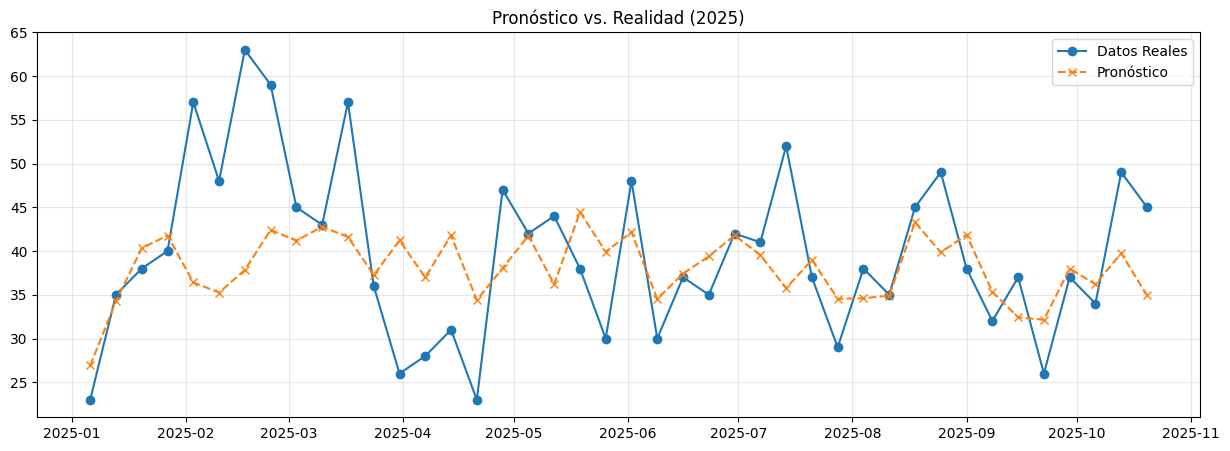


--- Métricas para el período: Total (2023-2025) ---
MAPE: 16.84%
RMSE: 8.84
MAE:  7.26


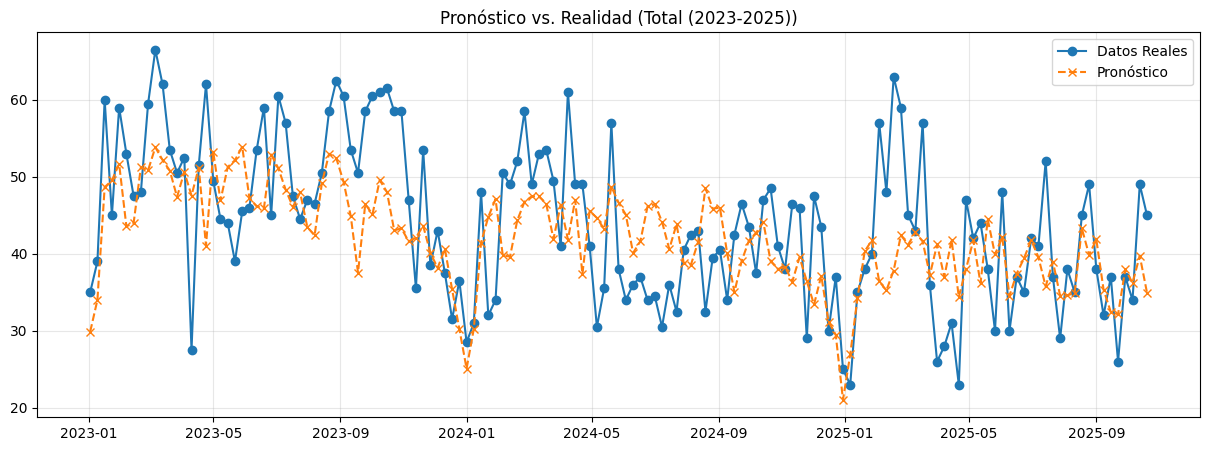


Componentes del Modelo Final (entrenado 2014-2022):


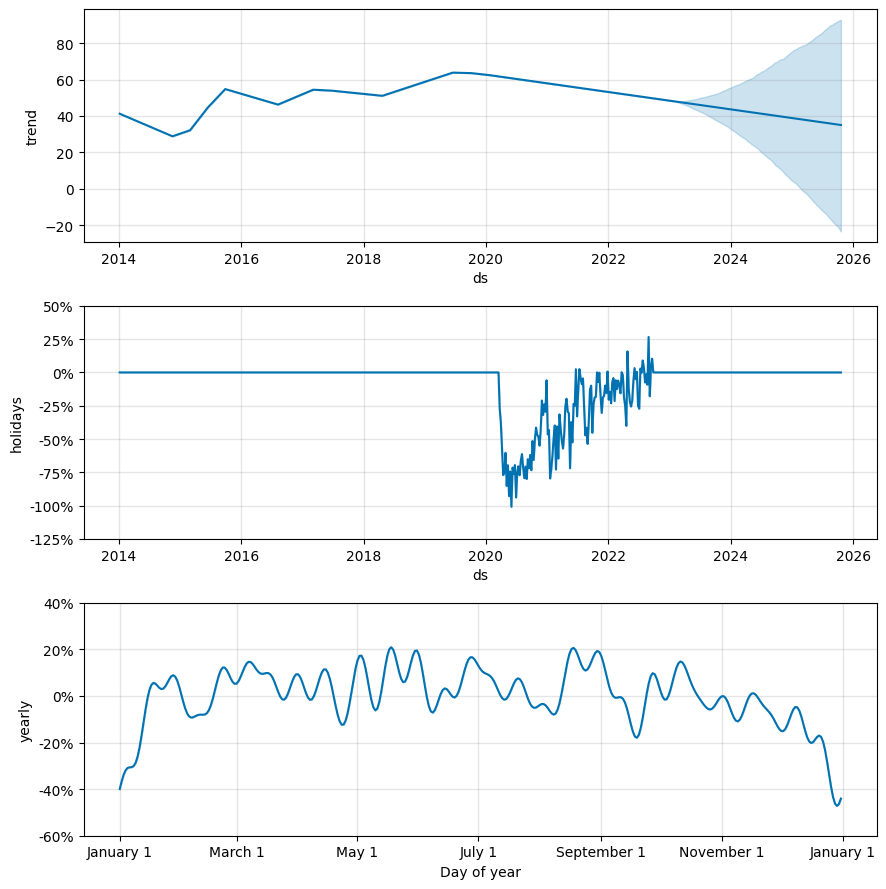

In [106]:
print("\n--- Paso 6: Evaluación Multi-Periodo ---")

# Se definen las funciones para calcular y mostrar métricas
def calcular_metricas(df_eval_periodo, nombre_periodo):
    y_true = df_eval_periodo['y']
    y_pred = df_eval_periodo['yhat']
    
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n--- Métricas para el período: {nombre_periodo} ---")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")

# Se definen las funciones para graficar
def graficar_periodo(df_eval_periodo, nombre_periodo):
    plt.figure(figsize=(15, 5))
    plt.plot(df_eval_periodo['ds'], df_eval_periodo['y'], 'o-', label='Datos Reales')
    plt.plot(df_eval_periodo['ds'], df_eval_periodo['yhat'], 'x--', label='Pronóstico')
    plt.title(f'Pronóstico vs. Realidad ({nombre_periodo})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- 1. Evaluación 2023 (Año 1) ---
df_eval_2023 = df_eval[df_eval['ds'].dt.year == 2023]
calcular_metricas(df_eval_2023, "2023 (Año 1 del Pronóstico)")
graficar_periodo(df_eval_2023, "2023")

# --- 2. Evaluación 2024 (Año 2) ---
df_eval_2024 = df_eval[df_eval['ds'].dt.year == 2024]
calcular_metricas(df_eval_2024, "2024 (Año 2 del Pronóstico)")
graficar_periodo(df_eval_2024, "2024")

# --- 3. Evaluación 2025 (Año 3) ---
df_eval_2025 = df_eval[df_eval['ds'].dt.year == 2025]
calcular_metricas(df_eval_2025, "2025 (Año 3 del Pronóstico)")
graficar_periodo(df_eval_2025, "2025")

# --- 4. Evaluación Combinada (2023-2025) ---
calcular_metricas(df_eval, "Total (2023-2025)")
graficar_periodo(df_eval, "Total (2023-2025)")

# --- 5. Visualización de Componentes ---
print("\nComponentes del Modelo Final (entrenado 2014-2022):")
fig_components = modelo_final_nacional.plot_components(forecast_final)
plt.show()

### Paso 7: Guardado de Resultados del Pronóstico (2023-2025)

Como paso final, se exportarán los resultados del pronóstico a 3 años (2023-2025) a un nuevo archivo CSV. Este archivo contendrá las fechas, los valores reales y las predicciones del modelo, permitiendo un análisis externo y la fácil reutilización de estos resultados.

In [100]:
print("\n--- Paso 7: Guardando Resultados del Pronóstico (2023-2025) ---")

# 1. Se parte del DataFrame 'df_eval' (creado en el Paso 6)
#    Este DataFrame ya contiene 'ds' (Fecha), 'y' (Real), 'yhat' (Predicción)

# 2. Se añaden columnas de 'Año' y 'Semana' para facilitar el análisis
df_resultados_final = df_eval.copy()
df_resultados_final['Año'] = df_resultados_final['ds'].dt.year
df_resultados_final['Semana'] = df_resultados_final['ds'].dt.isocalendar().week

# 3. Se seleccionan y renombran las columnas
df_exportar = df_resultados_final[[
    'ds',
    'Año',
    'Semana',
    'y',
    'yhat'
]].rename(columns={
    'ds': 'Fecha',
    'y': 'Real',
    'yhat': 'Predic'
})

# 4. Se define la ruta de salida
path_resultados = '../data/processed/forecast_results_2023-2025_(trained_on_2014-2022).csv'

# 5. Se guarda el archivo
df_exportar.to_csv(path_resultados, index=False, float_format='%.2f')

print(f"Resultados del pronóstico guardados exitosamente en:")
print(path_resultados)
print(df_exportar.head())


--- Paso 7: Guardando Resultados del Pronóstico (2023-2025) ---
Resultados del pronóstico guardados exitosamente en:
../data/processed/forecast_results_2023-2025_(trained_on_2014-2022).csv
       Fecha   Año  Semana  Real     Predic
0 2023-01-02  2023       1  35.0  30.736746
1 2023-01-09  2023       2  39.0  34.685221
2 2023-01-16  2023       3  60.0  47.863534
3 2023-01-23  2023       4  45.0  50.786643
4 2023-01-30  2023       5  59.0  51.321031
